In [40]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
import os
import numpy as np
import json
import cv2
import pandas as pd
from detectron2.structures import BoxMode
import functools
import operator
print(torch.__version__, torch.cuda.is_available()) # 1.5.0+cu101 True

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from os import listdir
from os.path import isfile, isdir, join
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging

setup_logger()

1.7.0+cu110 True


<Logger detectron2 (DEBUG)>

In [2]:
data_dir = '../data/train'


In [3]:
def read_img(path, image_id, color, image_size=None):
    filename = f'{path}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.max() > 255:
        img_max = img.max()
        img = (img/255).astype('uint8')
    return img

# image loader, using rgb only here
def load_RGBY_image(path, image_id, image_size=None):
    red = read_img(path, image_id, "red", image_size)
    green = read_img(path, image_id, "green", image_size)
    blue = read_img(path, image_id, "blue", image_size)

    stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
    return stacked_images
    

def load_mask(image_id, image_size=None):
    """Generate instance masks for an image.
   Returns:
    masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
    class_ids: a 1D array of class IDs of the instance masks.
    """
    # Read mask files from 
    masks = []
    class_ids = []
    cell_mask = np.load(f'{mask_dir}/{image_id}.npz')['arr_0']
    if image_size is not None:
        cell_mask = cv2.resize(cell_mask, (image_size, image_size), interpolation=cv2.INTER_NEAREST)

    #find number of cells in the image
    mask_ids = np.unique(cell_mask)

    #Remove background
    mask_ids = mask_ids[1:]

    #create binary mask for every cell in the image
    masks = cell_mask == mask_ids[:,None, None]

    # Return mask, and array of class IDs of each instance. Since we have
    # one class ID, we return an array of ones
    return masks, mask_ids


In [9]:
# from sklearn.model_selection import train_test_split
# df = pd.read_csv('../data/train.csv')
# #dropping this image since it has no masks
# df.drop(df[df['ID']=='940f418a-bba4-11e8-b2b9-ac1f6b6435d0'].index, inplace = True)  

# #Split labels
# df["Label"] = df["Label"].str.split("|")

# #fetch only images that have one label
# df["Label Count"] = df['Label'].str.len()
# df = df[df['Label Count'] == 1]
# df['Label'] = df['Label'].apply(lambda x: int(x[0]))

# df = df[df['Label'] != 11]
# print(len(df))
# train_size = 0.70
# val_size = 0.10
# test_size = 0.20
# print(df['Label'].value_counts())

# X_train, X_temp = train_test_split(df, test_size=(1.0-train_size),stratify=df['Label'], random_state=42)
# rel_test_size = test_size / (val_size + test_size)
# X_val, X_test = train_test_split(X_temp, test_size=rel_test_size,stratify=X_temp['Label'] ,random_state=42)

# print(len(X_train), len(X_val), len(X_test))
# X_train.to_csv("./data/train_split.csv",index=False)
# X_val.to_csv("./data/val_split.csv",index=False)
# X_test.to_csv("./data/test_split.csv",index=False)

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("hpa_train_final", {}, "./data/hpa_cocoformat_train.json", data_dir)
register_coco_instances("hpa_val_final", {}, "./data/hpa_cocoformat_val.json", data_dir )
register_coco_instances("hpa_test_final", {}, "./data/hpa_cocoformat_test.json", data_dir)

In [6]:
train_metadata = MetadataCatalog.get("hpa_train_final")
dataset_dicts_train = DatasetCatalog.get("hpa_train_final")

val_metadata = MetadataCatalog.get("hpa_val_final")
dataset_dicts_val = DatasetCatalog.get("hpa_val_final")

test_metadata = MetadataCatalog.get("hpa_test_final")
dataset_dicts_test = DatasetCatalog.get("hpa_test_final")


[04/25 17:46:18 d2.data.datasets.coco]: Loading ./data/hpa_cocoformat_train.json takes 21.68 seconds.
[04/25 17:46:18 d2.data.datasets.coco]: Loaded 7286 images in COCO format from ./data/hpa_cocoformat_train.json
[04/25 17:46:25 d2.data.datasets.coco]: Loading ./data/hpa_cocoformat_val.json takes 2.60 seconds.
[04/25 17:46:25 d2.data.datasets.coco]: Loaded 1041 images in COCO format from ./data/hpa_cocoformat_val.json
[04/25 17:46:32 d2.data.datasets.coco]: Loading ./data/hpa_cocoformat_test.json takes 6.86 seconds.
[04/25 17:46:32 d2.data.datasets.coco]: Loaded 2083 images in COCO format from ./data/hpa_cocoformat_test.json


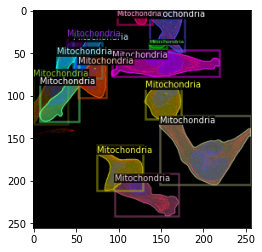

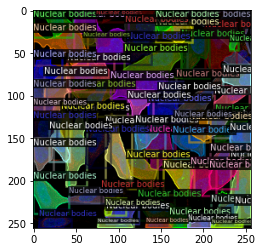

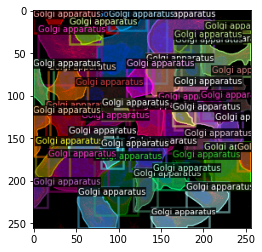

In [8]:
#visualize training data
import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts_train, 3):
    img_id = d['file_name'].split("/")[-1]
    img = load_RGBY_image(data_dir, img_id, image_size=512)
    visualizer = Visualizer(img, metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())


In [36]:
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
import copy

def custom_train_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    file = dataset_dict['file_name'].split('/')
    image = load_RGBY_image(data_dir, file[-1], image_size=512)
    image = image[:, :, ::-1] #Flip to convert to BGR
    
    transform_list = [
                          T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                          T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      ]
    
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

def custom_val_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    file = dataset_dict['file_name'].split('/')
    image = load_RGBY_image(data_dir, file[-1], image_size=512)
    image = image[:, :, ::-1] #Flip to convert to BGR
    
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
    
    instances = utils.annotations_to_instances(dataset_dict['annotations'], image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    return dataset_dict

In [41]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [42]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class Trainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains a number pre-defined logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can use the cleaner
    "SimpleTrainer", or write your own training loop.
    """

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_train_mapper)
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=custom_val_mapper)
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, output_dir=output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0], mapper=custom_val_mapper)
        ))
        return hooks

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("hpa_train_final",)
cfg.DATASETS.TEST = ("hpa_val_final",)
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 300000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = ()

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 19
cfg.TEST.EVAL_PERIOD = 1000
cfg.OUTPUT_DIR = './output/increased_iter'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/25 20:21:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (76, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (76,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (19, 256, 1, 

[04/25 20:22:30 d2.engine.train_loop]: Starting training from iteration 0
[04/25 20:22:47 d2.utils.events]:  eta: 2 days, 14:22:51  iter: 19  total_loss: 6.061  loss_cls: 3.078  loss_box_reg: 0.8888  loss_mask: 0.6927  loss_rpn_cls: 1.228  loss_rpn_loc: 0.1594  time: 0.7538  data_time: 0.1567  lr: 4.9953e-06  max_mem: 7083M
[04/25 20:23:02 d2.utils.events]:  eta: 2 days, 14:25:20  iter: 39  total_loss: 5.518  loss_cls: 2.932  loss_box_reg: 0.8904  loss_mask: 0.6926  loss_rpn_cls: 0.8572  loss_rpn_loc: 0.1604  time: 0.7524  data_time: 0.0499  lr: 9.9902e-06  max_mem: 7083M
[04/25 20:23:17 d2.utils.events]:  eta: 2 days, 14:26:57  iter: 59  total_loss: 4.891  loss_cls: 2.701  loss_box_reg: 0.8837  loss_mask: 0.6918  loss_rpn_cls: 0.4922  loss_rpn_loc: 0.1566  time: 0.7533  data_time: 0.0493  lr: 1.4985e-05  max_mem: 7083M
[04/25 20:23:32 d2.utils.events]:  eta: 2 days, 14:31:35  iter: 79  total_loss: 4.45  loss_cls: 2.396  loss_box_reg: 0.9006  loss_mask: 0.6912  loss_rpn_cls: 0.3109  lo

In [27]:
%load_ext tensorboard
%tensorboard --logdir output/increased_iter

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [44]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

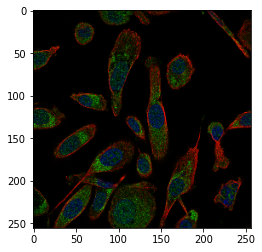

In [48]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts_test, 3):    
    img_id = d['file_name'].split("/")[-1]
    img = load_RGBY_image(data_dir, img_id, image_size=512)
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(img,
                   metadata=test_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())